In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from random import randint

In [ ]:
data = pd.read_csv('houses.csv', index_col=0)

In [3]:
data.head()

,id,area,space,equipment,type,room,city,state,price,capacity,extra
0,39,600,300,12,ویلایی,3,نمک آبرود,مازندران,500000,8,7
1,52,312,75,9,ویلایی,1,طالقان,البرز,250000,4,2
2,79,114,85,10,آپارتمان,1,کاشان,اصفهان,100000,4,6
3,87,400,200,12,ویلایی,3,نمک آبرود,مازندران,1000000,6,6
4,101,500,120,8,آپارتمان,2,نمک آبرود,مازندران,250000,5,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4785 entries, 0 to 4784
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         4785 non-null   int64 
 1   area       4785 non-null   int64 
 2   space      4785 non-null   int64 
 3   equipment  4785 non-null   int64 
 4   type       4785 non-null   object
 5   room       4785 non-null   int64 
 6   city       4785 non-null   object
 7   state      4785 non-null   object
 8   price      4785 non-null   int64 
 9   capacity   4785 non-null   int64 
 10  extra      4785 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 448.6+ KB


In [5]:
data.describe()

,id,area,space,equipment,room,price,capacity,extra
count,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4.785000e+03,4785.000000,4785.000000
mean,28950.464159,2094.212539,117.513480,8.256635,1.123302,3.457045e+05,3.523093,3.588715
std,12101.208762,18788.321700,220.447082,2.169878,1.115531,4.469819e+05,2.288170,4.298892
min,39.000000,1.000000,4.000000,0.000000,0.000000,2.500000e+04,1.000000,0.000000
25%,20846.000000,220.000000,24.000000,7.000000,0.000000,1.000000e+05,2.000000,1.000000
50%,32008.000000,500.000000,75.000000,8.000000,1.000000,2.200000e+05,4.000000,3.000000
75%,37832.000000,1000.000000,120.000000,10.000000,2.000000,4.000000e+05,5.000000,4.000000
max,48034.000000,570000.000000,4000.000000,14.000000,11.000000,7.500000e+06,45.000000,84.000000


# Preprocessing

In [6]:
data['type'].value_counts()

بوم‌گردی    1888
ویلایی      1502
آپارتمان    1109
سوئیت        286
Name: type, dtype: int64

In [7]:
data['city'].value_counts()

تهران        233
رامسر        207
یزد          202
اصفهان       174
تالش         172
            ... 
خشک بیجار      1
پیرانشهر       1
هشتگرد         1
شاهین شهر      1
دزفول          1
Name: city, Length: 264, dtype: int64

In [8]:
data['state'].value_counts()

مازندران               894
گیلان                  810
اصفهان                 524
هرمزگان                293
تهران                  284
یزد                    259
خراسان رضوی            242
فارس                   200
سمنان                  134
کرمان                  115
خراسان جنوبی           113
البرز                  111
گلستان                 106
همدان                   82
بوشهر                   75
خوزستان                 52
اردبیل                  52
چهارمحال و بختیاری      50
آذربایجان غربی          47
آذربایجان شرقی          40
خراسان شمالی            38
کرمانشاه                38
لرستان                  37
کردستان                 32
قزوین                   32
سیستان و بلوچستان       29
مرکزی                   29
قم                      26
زنجان                   20
کهکیلویه و بویراحمد     12
ایلام                    9
Name: state, dtype: int64

## Encoding

In [9]:
# drop ID

dropped_data = data.drop(['id', 'city'], axis=1)

In [10]:
# OneHot encoding for 'type' and 'state'

oneHot_encoder = OneHotEncoder()
def OneHot(df):
    columns = set()
    count_different_values = len(df.value_counts().index)
    for value in df:
        if len(columns) == count_different_values:
            break
        columns.add(value)
        
    columns = list(columns)
    encoded_data = pd.get_dummies(df)
    return pd.DataFrame(encoded_data)
        
encoded_data = pd.concat([dropped_data, OneHot(data['type'])], axis=1)
encoded_data = pd.concat([encoded_data, OneHot(data['state'])], axis=1)
encoded_data.drop(['state', 'type'], axis=1, inplace=True)
encoded_data

,area,space,equipment,room,price,capacity,extra,آپارتمان,بوم‌گردی,سوئیت,ویلایی,آذربایجان شرقی,آذربایجان غربی,اردبیل,اصفهان,البرز,ایلام,بوشهر,تهران,خراسان جنوبی,خراسان رضوی,خراسان شمالی,خوزستان,زنجان,سمنان,سیستان و بلوچستان,فارس,قزوین,قم,لرستان,مازندران,مرکزی,هرمزگان,همدان,چهارمحال و بختیاری,کردستان,کرمان,کرمانشاه,کهکیلویه و بویراحمد,گلستان,گیلان,یزد
0,600,300,12,3,500000,8,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,312,75,9,1,250000,4,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,114,85,10,1,100000,4,6,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,400,200,12,3,1000000,6,6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,500,120,8,2,250000,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4780,3000,150,11,2,1000000,4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4781,4000,110,10,1,330000,4,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4782,400,30,11,0,130000,3,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4783,400,20,10,0,100000,2,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## New feature

In [11]:
encoded_data['spacePerPerson'] = encoded_data['space']/encoded_data['capacity']
encoded_data['areaPerPerson'] = encoded_data['area']/encoded_data['capacity']

In [12]:
encoded_data['capPlusExtra'] = encoded_data['capacity'] + encoded_data['extra']

In [13]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4785 entries, 0 to 4784
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   area                 4785 non-null   int64  
 1   space                4785 non-null   int64  
 2   equipment            4785 non-null   int64  
 3   room                 4785 non-null   int64  
 4   price                4785 non-null   int64  
 5   capacity             4785 non-null   int64  
 6   extra                4785 non-null   int64  
 7   آپارتمان             4785 non-null   uint8  
 8   بوم‌گردی             4785 non-null   uint8  
 9   سوئیت                4785 non-null   uint8  
 10  ویلایی               4785 non-null   uint8  
 11  آذربایجان شرقی       4785 non-null   uint8  
 12  آذربایجان غربی       4785 non-null   uint8  
 13  اردبیل               4785 non-null   uint8  
 14  اصفهان               4785 non-null   uint8  
 15  البرز                4785 non-null   u

## Data normalization

In [14]:
# normalize data

scaler = Normalizer()
normalized_data = encoded_data.drop(['price'], axis=1)
normalized_data = pd.DataFrame(scaler.fit_transform(normalized_data), index=normalized_data.index, columns=normalized_data.columns)

In [15]:
X = normalized_data.copy()
y = encoded_data['price']

In [16]:
# split train and test data

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.1)

## Select feature

In [17]:
# calculate Mutual information

def make_mi_scores(xtrain, ytrain):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(xtrain, ytrain)
mi_scores

capacity               1.026159
areaPerPerson          1.017533
area                   0.921657
بوم‌گردی               0.893488
equipment              0.816521
space                  0.773575
spacePerPerson         0.744787
capPlusExtra           0.654951
extra                  0.567155
room                   0.387824
ویلایی                 0.217424
آپارتمان               0.180170
اصفهان                 0.124501
مازندران               0.122833
یزد                    0.114400
گیلان                  0.112092
خراسان رضوی            0.108023
خراسان جنوبی           0.080675
هرمزگان                0.079451
کرمان                  0.077621
تهران                  0.075080
سمنان                  0.069777
سوئیت                  0.056203
همدان                  0.049583
خراسان شمالی           0.048790
بوشهر                  0.044365
فارس                   0.044174
خوزستان                0.042632
البرز                  0.032800
آذربایجان غربی         0.024877
قزوین                  0.023603
گلستان  

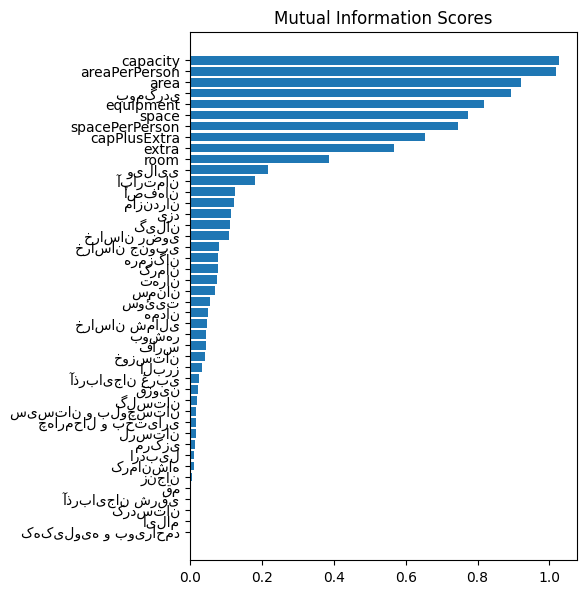

In [18]:
# plot Mutual information

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(5, 7))
plot_mi_scores(mi_scores)

In [19]:
# drop columns with 0  mutual_info_regression

columns = list(mi_scores[mi_scores > 0].index)

xtrain_newFeatures = xtrain[columns]
xtest_newFeatures = xtest[columns]
xvalid_newFeatures = xvalid[columns]

# Select model

In [20]:
# make and fit model and print scores

def MakeModel(model, xtrain, ytrain, xvalid, yvalid, key=1):
  if key:
    model.fit(xtrain, ytrain)
  score = MAE(ytrain, model.predict(xtrain))
  print('train_score : {0:0.2f}'.format(score))
  print()
  score = MAE(yvalid, model.predict(xvalid))
  print('valid_score : {0:0.2f}'.format(score))

In [21]:
from sklearn.tree import DecisionTreeRegressor

MakeModel(DecisionTreeRegressor(random_state=42), xtrain_newFeatures, ytrain, xvalid_newFeatures, yvalid)

train_score : 2530.71

valid_score : 169795.89


In [22]:
from sklearn.ensemble import RandomForestRegressor

MakeModel(RandomForestRegressor(random_state=42), xtrain_newFeatures, ytrain, xvalid_newFeatures, yvalid)

train_score : 45875.32

valid_score : 133825.11


In [23]:
from sklearn.neighbors import KNeighborsRegressor

MakeModel(KNeighborsRegressor(), xtrain_newFeatures, ytrain, xvalid_newFeatures, yvalid)

train_score : 137096.89

valid_score : 175644.68


In [24]:
from sklearn.neural_network import MLPRegressor

MakeModel(MLPRegressor(), xtrain_newFeatures, ytrain, xvalid_newFeatures, yvalid)

train_score : 339691.07

valid_score : 360059.73


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [25]:
from sklearn.ensemble import GradientBoostingRegressor as GBoost

MakeModel(GBoost(random_state=42), xtrain_newFeatures, ytrain, xvalid_newFeatures, yvalid)

train_score : 126805.05

valid_score : 141008.01


In [26]:
from sklearn.linear_model import LinearRegression

MakeModel(LinearRegression(), xtrain_newFeatures, ytrain, xvalid_newFeatures, yvalid)

train_score : 199076.50

valid_score : 195537.65


In [27]:
from sklearn.svm import SVR

MakeModel(SVR(), xtrain_newFeatures, ytrain, xvalid_newFeatures, yvalid)

train_score : 225925.37

valid_score : 237689.78


# Fine-tune 

In [42]:
# fine-tune 

# Setup the parameters and distributions to sample from: param_grid
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

# Instantiate a Decision Tree Regressor: tree
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_grid, cv=5, verbose=1)

# Fit it to the data
tree_cv.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   31.3s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='d

# Evaluate Model

In [44]:
MakeModel(tree_cv, xtrain, ytrain, xvalid, yvalid, 0)

train_score : 134865.30

valid_score : 146913.36


In [47]:
score = MAE(ytest, tree_cv.predict(xtest))
print('Final-model-score : {0:0.2f}'.format(score))

Final-model-score : 138893.94
